In [21]:
from IPython import get_ipython
from IPython.display import display
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load transaction data
transaction_file = '/content/drive/MyDrive/Copy of transaction_data.csv'
purchase_file = '/content/drive/MyDrive/Copy of purchase_behaviour.csv'

df_transactions = pd.read_csv(transaction_file)
df_purchases = pd.read_csv(purchase_file)

# Display basic info
display(df_transactions.head())
display(df_purchases.head())

# Merge data on customer ID or relevant key
# Assuming 'LYLTY_CARD_NBR' is the customer ID in df_transactions
if 'LYLTY_CARD_NBR' in df_transactions.columns and 'LYLTY_CARD_NBR' in df_purchases.columns:
    df = df_transactions.merge(df_purchases, on='LYLTY_CARD_NBR', how='left')  # Changed to LYLTY_CARD_NBR
else:
    raise ValueError("Key column 'LYLTY_CARD_NBR' not found in both files") # Changed to LYLTY_CARD_NBR

display(df.head())

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget


In [22]:
# %%
# ------------------------------ CHUNK 1: PROFITABILITY ANALYSIS ------------------------------
# Profit Calculation (assuming profit = revenue - cost)
# Check if 'TOT_SALES' and a cost column exist (replace 'cost_column_name' if needed)
# Assuming 'TOT_SALES' represents total revenue for a product in a transaction
# and 'PROD_QTY' represents the quantity of that product sold in the transaction
df['PROD_PRICE'] = df['TOT_SALES'] / df['PROD_QTY']

# Now you can proceed with the profit calculation:
df['revenue'] = df['TOT_SALES']
df['cost'] = df['PROD_QTY'] * df['PROD_PRICE']
df['profit'] = df['revenue'] - df['cost']
# Identify top 3 most profitable products
top_products = df.groupby('PROD_NAME')['profit'].sum().sort_values(ascending=False).head(3)
print("Top 3 most profitable products:")
print(top_products)
# %%

Top 3 most profitable products:
PROD_NAME
Twisties Cheese     Burger 250g            1.065814e-14
Infuzions Mango     Chutny Papadums 70g    1.776357e-15
Grain Waves Sour    Cream&Chives 210G      8.881784e-16
Name: profit, dtype: float64


In [23]:
# ------------------------------ CHUNK 2: CUSTOMER LOYALTY ANALYSIS ------------------------------
# Identify characteristics of most loyal customers
loyal_customers = df.groupby('LYLTY_CARD_NBR').agg({
    'TXN_ID': 'count',  # Frequency of purchases using TXN_ID instead of transaction_id
    'profit': 'sum',  # Total profit contribution
    'PROD_NBR': lambda x: x.nunique(),  # Diversity of purchases using PROD_NBR instead of product_id
}).rename(columns={'TXN_ID': 'purchase_count', 'PROD_NBR': 'unique_products'})

# Define loyalty criteria (Top 20% in purchase count & profit)
thresh_purchase = loyal_customers['purchase_count'].quantile(0.8)
thresh_profit = loyal_customers['profit'].quantile(0.8)

loyal_customers = loyal_customers[(loyal_customers['purchase_count'] >= thresh_purchase) &
                                  (loyal_customers['profit'] >= thresh_profit)]

# Merge with customer attributes
df_loyal = loyal_customers.merge(df_purchases, on='LYLTY_CARD_NBR', how='left')

# Deeper Segmentation (Lifestage and Premium Customer Status)
loyal_segments = df_loyal.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
loyal_segments['proportion'] = loyal_segments['LYLTY_CARD_NBR'] / loyal_segments['LYLTY_CARD_NBR'].sum()
print("\nLoyal Customer Segments:")
print(loyal_segments)

# CLTV Calculation (Example)
# (Requires historical data and appropriate CLTV model)
# Assuming 'profit' represents the profit per transaction
# and 'purchase_count' represents the total number of transactions
df_loyal['CLTV'] = df_loyal['profit'] * df_loyal['purchase_count']

# Analyze CLTV across segments
print("\nCLTV by Segment:")
print(df_loyal.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['CLTV'].mean())




Loyal Customer Segments:
                 LIFESTAGE PREMIUM_CUSTOMER  LYLTY_CARD_NBR  proportion
0   MIDAGE SINGLES/COUPLES           Budget             282    0.016738
1   MIDAGE SINGLES/COUPLES       Mainstream             691    0.041014
2   MIDAGE SINGLES/COUPLES          Premium             465    0.027600
3             NEW FAMILIES           Budget             108    0.006410
4             NEW FAMILIES       Mainstream              73    0.004333
5             NEW FAMILIES          Premium              39    0.002315
6           OLDER FAMILIES           Budget            2054    0.121914
7           OLDER FAMILIES       Mainstream            1284    0.076211
8           OLDER FAMILIES          Premium            1024    0.060779
9    OLDER SINGLES/COUPLES           Budget            1076    0.063865
10   OLDER SINGLES/COUPLES       Mainstream            1094    0.064934
11   OLDER SINGLES/COUPLES          Premium            1045    0.062025
12                RETIREES           B

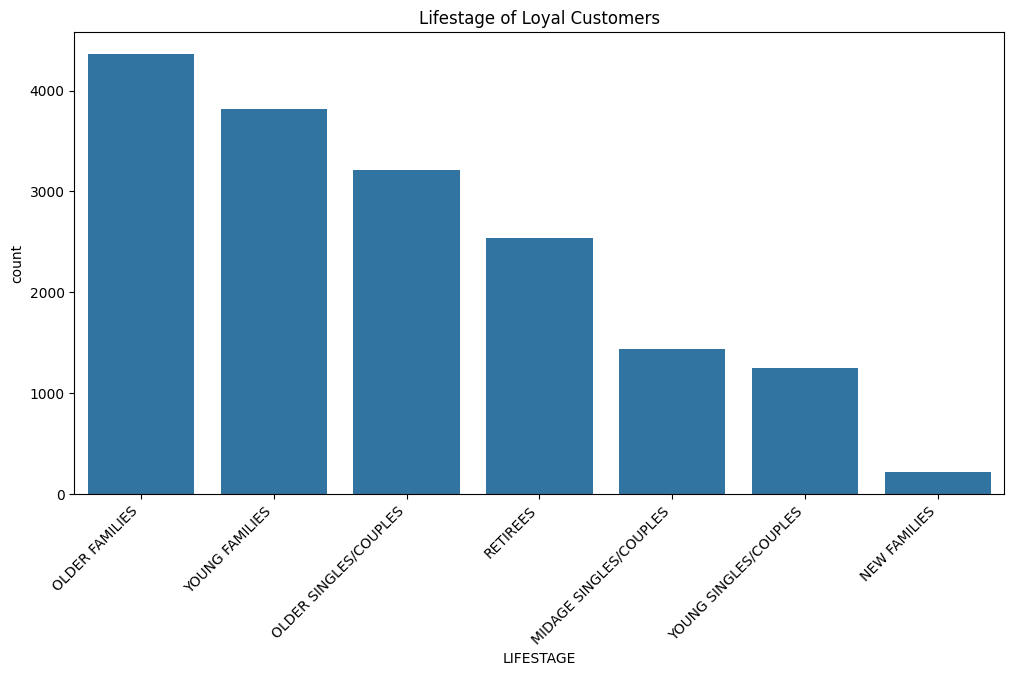

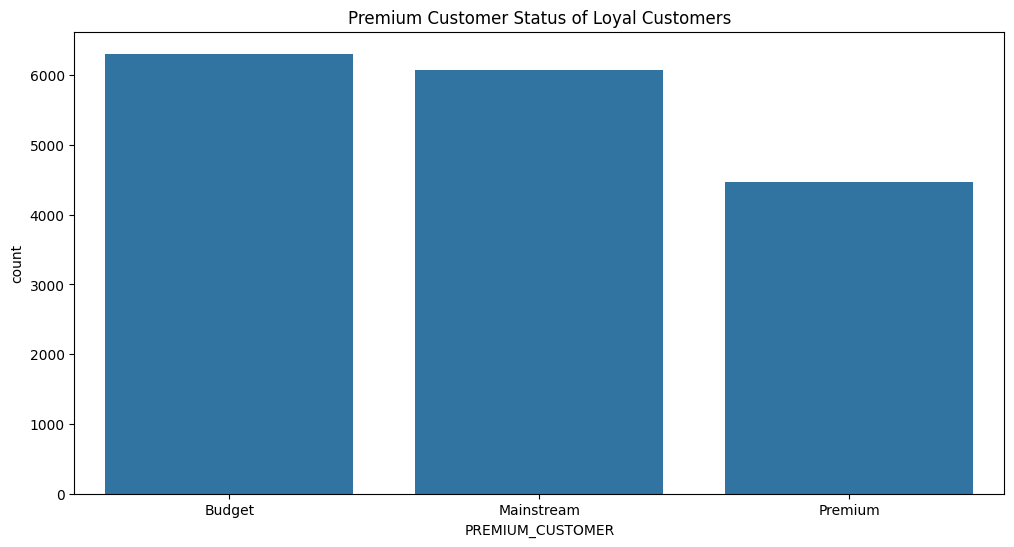

In [24]:
# %%
# ------------------------------ CHUNK 3: VISUALIZATION & DEEP INSIGHTS ------------------------------
# Plot characteristics
plt.figure(figsize=(12, 6))
sns.countplot(data=df_loyal, x='LIFESTAGE', order=df_loyal['LIFESTAGE'].value_counts().index)
plt.title("Lifestage of Loyal Customers")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df_loyal, x='PREMIUM_CUSTOMER', order=df_loyal['PREMIUM_CUSTOMER'].value_counts().index)
plt.title("Premium Customer Status of Loyal Customers")
plt.show()
# %%

In [25]:
# ------------------------------ CHUNK 4: HYPOTHESIS & INTERPRETATION ------------------------------
# Statistical Testing (Chi-squared test)
from scipy.stats import chi2_contingency

# Create contingency table for lifestage and loyalty
contingency_table = pd.crosstab(df['LIFESTAGE'], df['LYLTY_CARD_NBR'].isin(loyal_customers.index))

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-squared test for Lifestage and Loyalty: chi2={chi2:.2f}, p={p:.3f}")

# Similar tests can be performed for other attributes

# Calculate proportions for loyal customers
loyal_married_prop = df_loyal[df_loyal['LIFESTAGE'].str.contains('YOUNG SINGLES/COUPLES', na=False)]['LYLTY_CARD_NBR'].nunique() / df_loyal['LYLTY_CARD_NBR'].nunique()
loyal_employed_prop = df_loyal[df_loyal['LIFESTAGE'].str.contains('OLDER SINGLES/COUPLES', na=False)]['LYLTY_CARD_NBR'].nunique() / df_loyal['LYLTY_CARD_NBR'].nunique()
loyal_premium_prop = df_loyal[df_loyal['PREMIUM_CUSTOMER'] == 'Premium']['LYLTY_CARD_NBR'].nunique() / df_loyal['LYLTY_CARD_NBR'].nunique()


# Print the proportions
print(f"\nProportion of loyal customers who are married or have Young families: {loyal_married_prop:.2f}")
print(f"Proportion of loyal customers who are employed or have Older families: {loyal_employed_prop:.2f}")
print(f"Proportion of loyal customers who are premium buyers: {loyal_premium_prop:.2f}")

# Calculate proportions for overall customer base
overall_married_prop = df_purchases[df_purchases['LIFESTAGE'].str.contains('YOUNG SINGLES/COUPLES', na=False)]['LYLTY_CARD_NBR'].nunique() / df_purchases['LYLTY_CARD_NBR'].nunique()
overall_employed_prop = df_purchases[df_purchases['LIFESTAGE'].str.contains('OLDER SINGLES/COUPLES', na=False)]['LYLTY_CARD_NBR'].nunique() / df_purchases['LYLTY_CARD_NBR'].nunique()
overall_premium_prop = df_purchases[df_purchases['PREMIUM_CUSTOMER'] == 'Premium']['LYLTY_CARD_NBR'].nunique() / df_purchases['LYLTY_CARD_NBR'].nunique()

# Print the proportions
print(f"\nProportion of all customers who are married or have Young families: {overall_married_prop:.2f}")
print(f"Proportion of all customers who are employed or have Older families: {overall_employed_prop:.2f}")
print(f"Proportion of all customers who are premium buyers: {overall_premium_prop:.2f}")
# %%
print("\nInsights:")
if loyal_married_prop > overall_married_prop:
    print(f"- Loyal customers are more likely to be Young families/couples ({loyal_married_prop:.2f}) compared to the overall customer base ({overall_married_prop:.2f}).")
else:
    print(f"- Loyal customers are less likely to be Young families/couples ({loyal_married_prop:.2f}) compared to the overall customer base ({overall_married_prop:.2f}).")


if loyal_employed_prop > overall_employed_prop:
    print(f"- Loyal customers are more likely to be Older families/couples ({loyal_employed_prop:.2f}) compared to the overall customer base ({overall_employed_prop:.2f}).")
else:
    print(f"- Loyal customers are less likely to be Older families/couples ({loyal_employed_prop:.2f}) compared to the overall customer base ({overall_employed_prop:.2f}).")


if loyal_premium_prop > overall_premium_prop:
    print(f"- Loyal customers are more likely to be premium buyers ({loyal_premium_prop:.2f}) compared to the overall customer base ({overall_premium_prop:.2f}).")
else:
    print(f"- Loyal customers are less likely to be premium buyers ({loyal_premium_prop:.2f}) compared to the overall customer base ({overall_premium_prop:.2f}).")

# Hypothesis Formulation (Example)
# Based on deeper segmentation, statistical testing, and visualizations:
print("\n## Hypothesis:")
print("Customers in the 'Young Singles/Couples' and 'OLDER SINGLES/COUPLES' lifestage who are also premium buyers are more likely to be loyal due to their higher disposable income and preference for premium products.")


Chi-squared test for Lifestage and Loyalty: chi2=37485.07, p=0.000

Proportion of loyal customers who are married or have Young families: 0.07
Proportion of loyal customers who are employed or have Older families: 0.19
Proportion of loyal customers who are premium buyers: 0.26

Proportion of all customers who are married or have Young families: 0.20
Proportion of all customers who are employed or have Older families: 0.20
Proportion of all customers who are premium buyers: 0.26

Insights:
- Loyal customers are less likely to be Young families/couples (0.07) compared to the overall customer base (0.20).
- Loyal customers are less likely to be Older families/couples (0.19) compared to the overall customer base (0.20).
- Loyal customers are more likely to be premium buyers (0.26) compared to the overall customer base (0.26).

## Hypothesis:
Customers in the 'Young Singles/Couples' and 'OLDER SINGLES/COUPLES' lifestage who are also premium buyers are more likely to be loyal due to their h